<h2 style='color:blue' align='center'>Data Augmentation To Address Overfitting In Flower Classification CNN</h2>

**In this notebook we will build a CNN to classify flower images. We will also see how our model overfits and how overfitting can be addressed using data augmentation. Data augmentation is a process of generating new training samples from current training dataset using transformations such as zoom, rotations, change in contrast etc**

Credits: I used tensorflow offical tutorial: https://www.tensorflow.org/tutorials/images/classification as a reference and made bunch of changes to make it simpler

In below image, 4 new training samples are generated from original sample using different transformations

<img src="https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/17_data_augmentation/daisy2.JPG?raw=1" />

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

<h3 style='color:purple'>Load flowers dataset</h3>

this will create a folder called 'flower_photos' in your curent directory becuase we use cache_dir='.' means current directory and it will copy also the subdirectories.

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228827136/228813984 [==============================] - 1s 0us/step


In [3]:
data_dir

'./datasets/flower_photos'

Each operating system has different rules for constructing file paths. For example, Linux uses forward slashes for paths, while Windows uses backslashes.

This small difference can cause issues if you are working on a project and you want other developers who come from different operating systems to expand your code.

Fortunately, if you're coding in Python, the Pathlib module does the heavy lifting by letting you make sure that your file paths work the same in different operating systems. Also, it provides functionalities and operations to **help you save time while handling and manipulating paths**

In [5]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

- list all .jpg files path from any file :

In [6]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/sunflowers/1217254584_4b3028b93d.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/6606823367_e89dc52a95_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/6140693467_211a135b6d.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/3731075939_6c92d7fe68_m.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/4755075329_1fccc69d4e.jpg')]

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


- list all files path in the directory roses :

In [8]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/23891005905_17ce9e6936.jpg'),
 PosixPath('datasets/flower_photos/roses/15951588433_c0713cbfc6_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5180896559_b8cfefc21e.jpg'),
 PosixPath('datasets/flower_photos/roses/8692040971_826614516f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/118974357_0faa23cce9_n.jpg')]

- PIL to show quickly the image (must be a string not WindowsPath object use str() ):

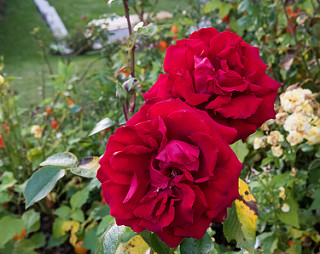

In [11]:
PIL.Image.open(str(roses[9]))

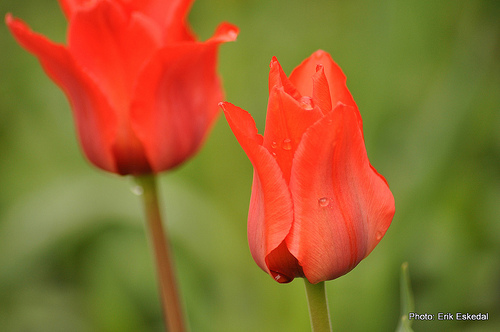

In [12]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

- create dict for every directory in the folder flower_photos :

In [13]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

- create labels useful wen we use y :

In [14]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [15]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/23891005905_17ce9e6936.jpg'),
 PosixPath('datasets/flower_photos/roses/15951588433_c0713cbfc6_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5180896559_b8cfefc21e.jpg'),
 PosixPath('datasets/flower_photos/roses/8692040971_826614516f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/118974357_0faa23cce9_n.jpg')]

In [16]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/23891005905_17ce9e6936.jpg'

- imread accept str, so use str() to transform PosixPath object to str object : 
(imread transform image to numpy array)

In [17]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [18]:
img.shape

(313, 500, 3)

- resize all image to  one (width, high) because our CNN accept just on size of images :

In [19]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [20]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [21]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images (help algo to run fast and uncrease accuracy)</h3>

In [23]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

<h3 style='color:purple'>Build convolutional neural network and train it</h3>

In [24]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # gives you a linear equation W*a+b, without softmax(it's from logits).
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)              

Epoch 1/30
86/86 [==============================] - 11s 22ms/step - loss: 1.3401 - accuracy: 0.4426
Epoch 2/30
86/86 [==============================] - 2s 22ms/step - loss: 0.9830 - accuracy: 0.6086
Epoch 3/30
86/86 [==============================] - 2s 22ms/step - loss: 0.8030 - accuracy: 0.6955
Epoch 4/30
86/86 [==============================] - 2s 22ms/step - loss: 0.6327 - accuracy: 0.7580
Epoch 5/30
86/86 [==============================] - 2s 22ms/step - loss: 0.4320 - accuracy: 0.8445
Epoch 6/30
86/86 [==============================] - 2s 22ms/step - loss: 0.2498 - accuracy: 0.9153
Epoch 7/30
86/86 [==============================] - 2s 22ms/step - loss: 0.1403 - accuracy: 0.9524
Epoch 8/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0805 - accuracy: 0.9786
Epoch 9/30
86/86 [==============================] - 2s 22ms/step - loss: 0.0562 - accuracy: 0.9840
Epoch 10/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0348 - accuracy: 0.9906
Epoch 11

In [25]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 1s 19ms/step - loss: 2.5183 - accuracy: 0.6514


[2.518311023712158, 0.6514161229133606]

**Here we see that while train accuracy is very high (99%), the test accuracy is significantly low (66.99%) indicating overfitting. Let's make some predictions before we use data augmentation to address overfitting**

In [26]:
predictions = model.predict(X_test_scaled)
predictions

array([[-2.4237990e+00,  2.2539961e+00, -5.3592753e+00, -2.5698335e+00,
        -1.7694820e-01],
       [ 6.9954686e+00, -2.6293123e+00, -1.7955512e+00, -7.8881912e+00,
         4.5320816e+00],
       [-1.7653214e+01, -1.8321270e+01,  1.2001271e+00,  6.9134359e+00,
        -4.8820167e+00],
       ...,
       [-1.6440441e+01, -2.4937595e+01, -3.5311651e+00,  2.1536371e+01,
         7.9592121e-01],
       [ 1.0732074e+01,  5.3453074e+00, -4.0058503e+00, -1.7629175e+01,
        -3.4188426e-01],
       [-9.5617104e+00,  7.8155808e-03,  2.4330323e+00,  1.0169754e+01,
        -9.6972036e+00]], dtype=float32)

In [27]:
score = tf.nn.softmax(predictions[0])

In [28]:
np.argmax(score)

1

In [29]:
y_test[0]

1

<h3 style='color:purple'>Improve Test Accuracy Using Data Augmentation</h3>

- we use a layers to do a data augmentation to every image :

In [31]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=X[0].shape),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

**Original Image**

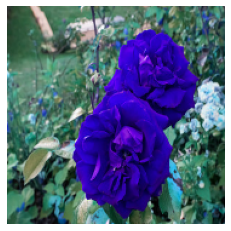

In [34]:
plt.axis('off')
plt.imshow(X[9])

**Newly generated training sample using data augmentation**

- we don't use data_augmentation(X[0]) because data_augmentation is a groupe of layers that takes a batchs as input :

- data_agmentation(X)[0] is a tensflow array type >>> we transforme it to numpy array :

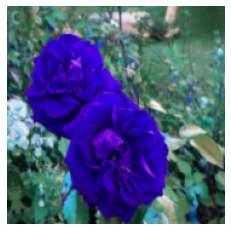

In [38]:
plt.axis('off')
plt.imshow(data_augmentation(X)[9].numpy().astype("uint8"))

<h3 style='color:purple'>Train the model using data augmentation and a drop out layer ( the input will pass to data_augmentation layers first)</h3>

In [39]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)    

Epoch 1/30
86/86 [==============================] - 4s 26ms/step - loss: 1.3361 - accuracy: 0.4288
Epoch 2/30
86/86 [==============================] - 2s 25ms/step - loss: 1.0694 - accuracy: 0.5698
Epoch 3/30
86/86 [==============================] - 2s 25ms/step - loss: 0.9813 - accuracy: 0.6152
Epoch 4/30
86/86 [==============================] - 2s 25ms/step - loss: 0.9113 - accuracy: 0.6464
Epoch 5/30
86/86 [==============================] - 2s 25ms/step - loss: 0.8484 - accuracy: 0.6715
Epoch 6/30
86/86 [==============================] - 2s 25ms/step - loss: 0.7917 - accuracy: 0.6962
Epoch 7/30
86/86 [==============================] - 2s 25ms/step - loss: 0.7622 - accuracy: 0.7086
Epoch 8/30
86/86 [==============================] - 2s 25ms/step - loss: 0.6982 - accuracy: 0.7344
Epoch 9/30
86/86 [==============================] - 2s 25ms/step - loss: 0.6741 - accuracy: 0.7355
Epoch 10/30
86/86 [==============================] - 2s 25ms/step - loss: 0.6527 - accuracy: 0.7456
Epoch 11/

In [40]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 1s 15ms/step - loss: 0.9409 - accuracy: 0.7233


[0.9409139752388, 0.7233115434646606]

**You can see that by using data augmentation and drop out layer the accuracy of test set predictions is increased to 73.74%**